In [17]:
# !pip install pillow
# !pip install opencv-python
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow==2.10
# !pip install scikit-learn

**Ini merupakan project computer vision untuk deteksi kantuk pengemudi kendaraan yang menggunakan algoritma Convolutional Neural Network (CNN) dengan pengimplementasian Transfer Learning VGG 16 menggunakan library tensorflow**

Dataset: https://www.kaggle.com/datasets/hazemfahmy/openned-closed-eyes/data

by Hazem Fahmy

**Tentang Dataset**

Selamat datang di Dataset Deteksi Kantuk UnityEyes! Dataset komprehensif ini dirancang untuk membantu para peneliti dan pengembang dalam tugas penting deteksi kantuk, yang secara khusus berfokus pada identifikasi pengemudi yang mengantuk berdasarkan perilaku mata. Dataset ini dikumpulkan menggunakan UnityEyes, sebuah simulator sintetis mata yang canggih, untuk memastikan data berkualitas tinggi. Data tersebut diberi label menggunakan ambang batas keterbukaan = 20 (referensi: https://github.com/SNTSVV/HUDD-Toolset)

Dataset Deteksi Mengantuk terdiri dari beragam koleksi rekaman gerakan mata dari subjek dengan demografi yang berbeda-beda, yang diambil dalam skenario mengemudi yang terkendali. Data tersebut mencakup urutan gambar mata, yang diberi label secara cermat untuk menunjukkan apakah mata terbuka atau tertutup, yang berfungsi sebagai kebenaran dasar untuk mendeteksi pengemudi yang mengantuk.

## **Import Library**

In [18]:
import os
import random
import numpy as np
import pandas as pd
from PIL import  Image
import string

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)

2.12.0


In [19]:
import warnings
# Abaikan semua warning
warnings.filterwarnings('ignore')

Beberapa fungsi library yang digunakan:
- **os**: Untuk mengoperasikan sistem operasi.
- **cv2**: OpenCV untuk tugas-tugas computer vision.
- **PIL**: Library pencitraan Python untuk tugas-tugas pemrosesan gambar.
- **numpy**: Untuk komputasi numerik dan matriks.
- **matplotlib.pyplot**: Untuk visualisasi plot.
- **seaborn**: Untuk visualisasi plot.
- **sklearn**: Untuk preprocessing data dan evaluasi akurasi
- **tensorflow**: Untuk membangun dan melatih model pembelajaran mesin.

## **Load Data from Directory**

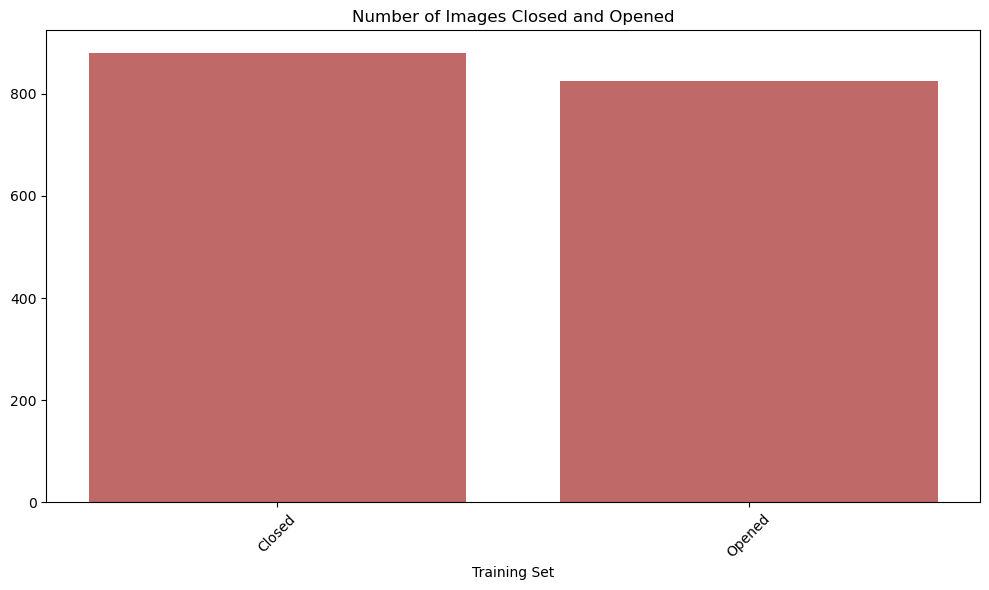

In [20]:
# directory yang mengandung Image
root_dir = './drownisess/TrainingSet/TrainingSet'

# Iterasi melalui setiap folder di direktori root
folder_image_count = {}

for data in os.listdir(root_dir):
    path_folder = os.path.join(root_dir, data)
    if os.path.isdir(path_folder):
        # Menghitung jumlah file gambar di dalam folder
        num_images = len([name for name in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
        folder_image_count[data] = num_images

# Extract nama folder dan jumlah gambar yang sesuai
folders = list(folder_image_count.keys())
img_counts = list(folder_image_count.values())

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(folders)), img_counts, color = 'brown', align='center', alpha=0.7)
plt.xticks(range(len(folders)), folders, rotation=45)
plt.xlabel('Training Set')
plt.title('Number of Images Closed and Opened')
plt.tight_layout()
plt.show()

Setelah melakukan exttact data dari direktori path yang telah ditentukan, di dapatkan data Training Set yang terdiri dari 2 data mata Terbuka dengan 824 gambar dan mata Mengantuk dengan 880 gambar. Pastikan folder dataset berada ditempat yang sama seperti folder .py atau jupyter anda.

Contoh direktori yang benar:

**Project**

----- **drownisess**
 
----- **drownisess-detection.ipynb**

## **Preprocessing Data**

Setelah dilakukan extract data, akan dilakukan transform data. Dataset akan dikelompokan berdasarkan label masing-masing lalu dilakukan resize image untuk mengcompress gambar mnejadi ukuran 150x150 dengan 3 channel warna karena merupakan gambar RGB.

In [21]:
categories = ['Opened', 'Closed'] # Folder yang akan dimuat
image_size = (150, 150) # Untuk setting ukuran gambar

# Inisialisasi list untuk menyimpan data dan label
X = []
Y = []

# Memuat gambar dan label dari setiap folder
for label, category in enumerate(categories):
    folder_path = os.path.join(root_dir, category)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(image_size)  # Mengubah ukuran gambar
            img_array = np.array(img)     # Mengonversi gambar menjadi array numpy
            X.append(img_array)
            Y.append(label)

# Mengonversi list X dan Y menjadi array numpy
X = np.array(X)
Y = np.array(Y)

Label mata terbuka **“Opened”: 0** dan Label mata mengantuk **“Closed”: 1**

In [22]:
print(f'Total gambar: {len(X)}')
print(f'Total label: {len(Y)}')
print('kode label:', np.unique(Y))

Total gambar: 1704
Total label: 1704
kode label: [0 1]


In [23]:
X[0]

array([[[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       ...,

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]]], dtype=uint8)

Melakukan load data yang telah di extract dan di transform untuk melihat 5 sampel masing-masing setiap label

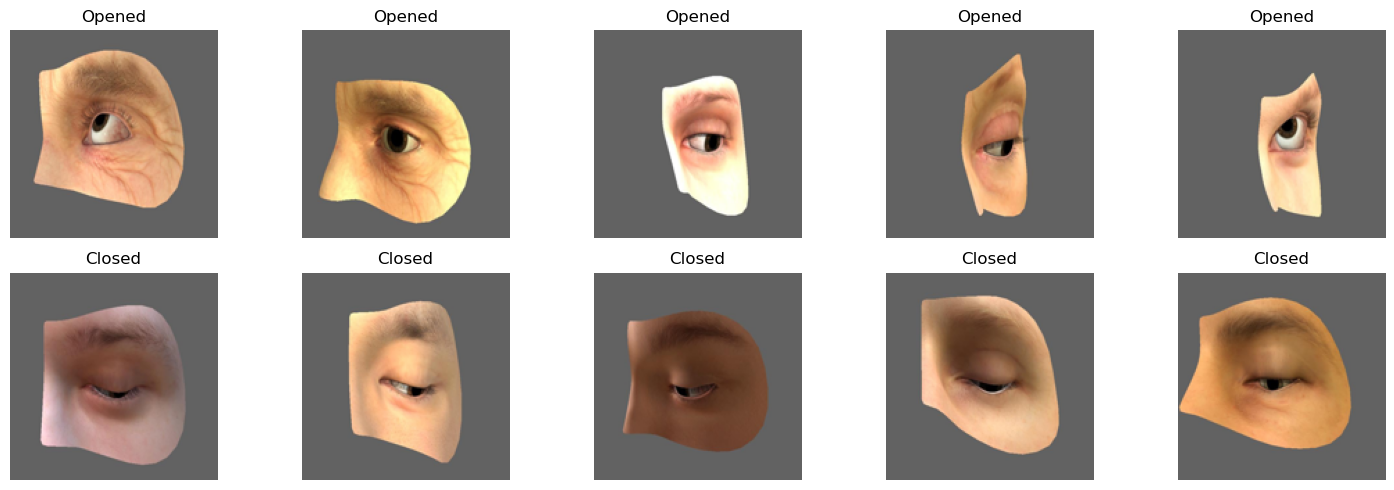

In [24]:
# Memisahkan gambar berdasarkan label
X_opened = X[Y == 0]
X_closed = X[Y == 1]

# Mengambil 5 sampel acak dari masing-masing kategori
opened_samples = np.random.choice(len(X_opened), 5, replace=False)
closed_samples = np.random.choice(len(X_closed), 5, replace=False)

X_samples = np.concatenate((X_opened[opened_samples], X_closed[closed_samples]))
Y_samples = np.concatenate((np.zeros(5), np.ones(5)))

# Menampilkan 10 sampel gambar
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_samples[i])
    plt.title('Opened' if Y_samples[i] == 0 else 'Closed')
    plt.axis('off')
plt.tight_layout()
plt.show()

Membagi data menjadi data training 90% dan data validation 10%

In [25]:
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.1, random_state=79)

In [26]:
print(x_train.shape)
print(y_train.shape)

(1533, 150, 150, 3)
(1533,)


terdapat 1533 gambar untuk data training

In [27]:
print(x_validation.shape)
print(y_validation.shape)

(171, 150, 150, 3)
(171,)


terdapat 171 gambar untuk data validation

In [28]:
# Mengonversi y_train dan y_validation menjadi kategorikal (one-hot encoded vectors.)
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)

## **Model 1 CNN + VGG16 [Trainable layer - Regularization Yes - Batch Size 32]**

Model pertama adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 dengan melakukan training layer VGG16, memakai regularization dan batch size = 32

In [29]:
# model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
# model.summary()

In [30]:
# # Load base model dengan VGG16
# base_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape = (150, 150, 3),
#     classes=2,
# )

# # Membuka 24 layer terakhir kecuali BatchNormalization
# base_model.trainable = True
# layer_count = len(base_model.layers)
# layer_count

In [31]:
# Define jumlah kelas
num_classes = 2

In [32]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka layer convolutional dan pooling tertentu untuk dilatih
conv_count, pool_count = 0, 0
for layer in reversed(base_model.layers):  # Iterasi dari belakang
    if isinstance(layer, tf.keras.layers.Conv2D) and conv_count < 5:
        layer.trainable = True
        conv_count += 1
    elif isinstance(layer, tf.keras.layers.MaxPooling2D) and pool_count < 3:
        layer.trainable = True
        pool_count += 1
    else:
        layer.trainable = False  # Freeze layer lainnya

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_VGG16_1
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)  # Menambahkan weight regularization
)(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_VGG16_1
model_VGG16_1 = Model(inputs, outputs)

# Compile model_VGG16_1
model_VGG16_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_1 = ModelCheckpoint(
    'best_model_VGG16_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_1 dengan batch size 32
batch_size = 32
historyVGG16_1 = model_VGG16_1.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_1, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 6.7111 - accuracy: 0.8532
Epoch 1: val_accuracy improved from -inf to 0.95906, saving model to best_model_VGG16_1.h5
48/48 [==============================] - 162s 3s/step - loss: 6.7111 - accuracy: 0.8532 - val_loss: 5.9147 - val_accuracy: 0.9591
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 5.5240 - accuracy: 0.9348
Epoch 2: val_accuracy improved from 0.95906 to 0.96491, saving model to best_model_VGG16_1.h5
48/48 [==============================] - 157s 3s/step - loss: 5.5240 - accuracy: 0.9348 - val_loss: 4.9743 - val_accuracy: 0.9649
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 4.5976 - accuracy: 0.9524
Epoch 3: val_accuracy did not improve from 0.96491
48/48 [==============================] - 157s 3s/step - loss: 4.5976 - accuracy: 0.9524 - val_loss: 4.2321 - val_accuracy: 0.9532
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 3.8442 - accuracy: 0.955

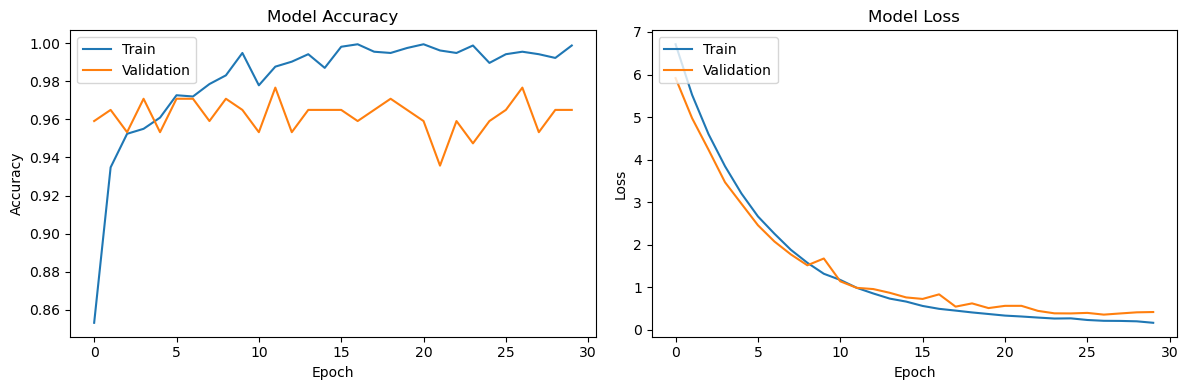

In [33]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_1.history['accuracy'])
ax1.plot(historyVGG16_1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_1.history['loss'])
ax2.plot(historyVGG16_1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_1.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_1.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_1 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 1:')
print(class_report_VGG16_1)

6/6 [==============================] - 9s 2s/step - loss: 0.4169 - accuracy: 0.9649
validation accuracy: 96.491%
validation loss: 0.4169
6/6 [==============================] - 9s 1s/step
Classification Report Model CNN + VGG16 1:
              precision    recall  f1-score   support

      Opened       0.99      0.94      0.96        87
      Closed       0.94      0.99      0.97        84

    accuracy                           0.96       171
   macro avg       0.97      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171



Confusion Matrix:
[[82  5]
 [ 1 83]]


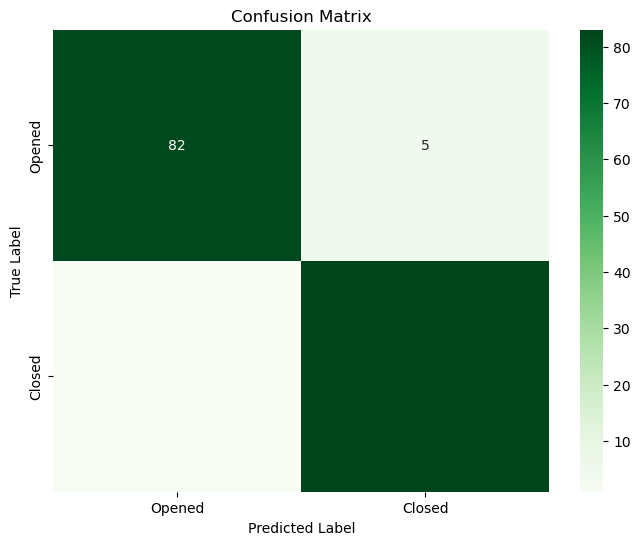

In [35]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 1**

1/1 [==============================] - 0s 79ms/step


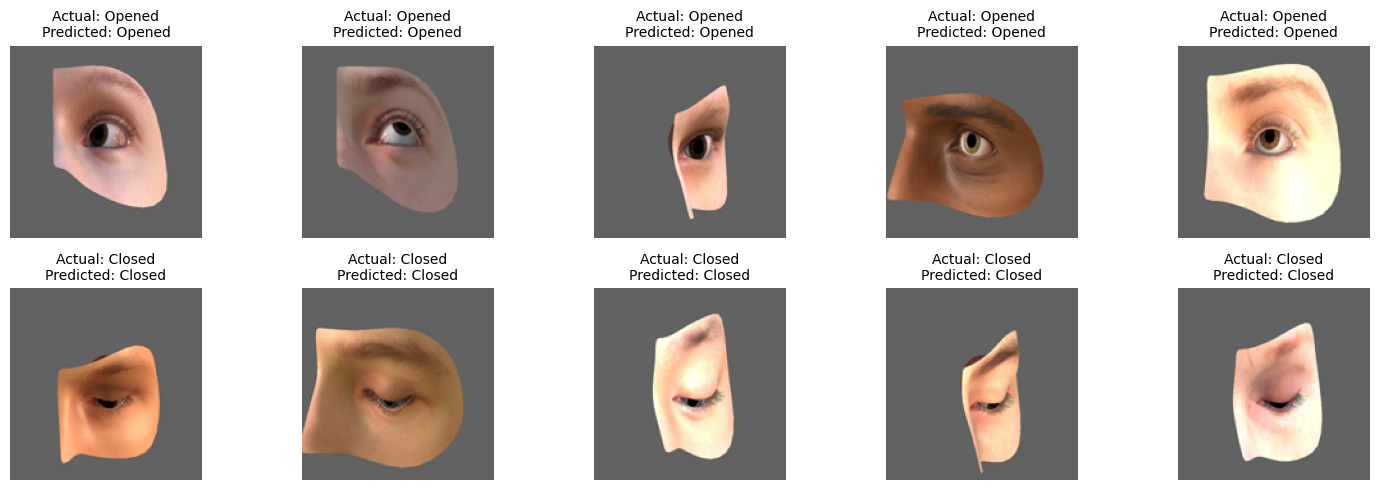

In [36]:
# Load model_predict_1 .h5
model_predict_1 = tf.keras.models.load_model('best_model_VGG16_1.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_1.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 2 CNN + VGG16 [No Trainable layer - Regularization Yes - Batch Size 32]**

Model kedua adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 tanpa melakukan training layer VGG16, memakai regularization dan batch size = 32

In [38]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_VGG16_2
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_VGG16_2
model_VGG16_2 = Model(inputs, outputs)

# Compile model_VGG16_2
model_VGG16_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_2 = ModelCheckpoint(
    'best_model_VGG16_2.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_2 dengan batch size 32
batch_size = 32
historyVGG16_2 = model_VGG16_2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_2, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 7.5284 - accuracy: 0.8056
Epoch 1: val_accuracy improved from -inf to 0.92398, saving model to best_model_VGG16_2.h5
48/48 [==============================] - 98s 2s/step - loss: 7.5284 - accuracy: 0.8056 - val_loss: 6.4897 - val_accuracy: 0.9240
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 6.4180 - accuracy: 0.8911
Epoch 2: val_accuracy improved from 0.92398 to 0.94737, saving model to best_model_VGG16_2.h5
48/48 [==============================] - 86s 2s/step - loss: 6.4180 - accuracy: 0.8911 - val_loss: 5.7267 - val_accuracy: 0.9474
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 5.7867 - accuracy: 0.8904
Epoch 3: val_accuracy did not improve from 0.94737
48/48 [==============================] - 87s 2s/step - loss: 5.7867 - accuracy: 0.8904 - val_loss: 5.1178 - val_accuracy: 0.9357
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 5.1451 - accuracy: 0.9008
E

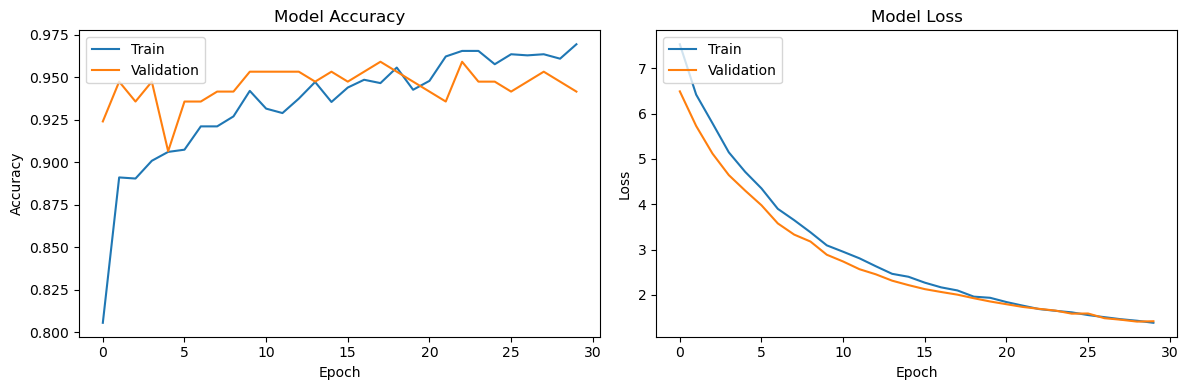

In [39]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_2.history['accuracy'])
ax1.plot(historyVGG16_2.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_2.history['loss'])
ax2.plot(historyVGG16_2.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_2.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_2.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_2 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 2:')
print(class_report_VGG16_2)

6/6 [==============================] - 9s 1s/step - loss: 1.4205 - accuracy: 0.9415
validation accuracy: 94.152%
validation loss: 1.4205
6/6 [==============================] - 8s 1s/step
Classification Report Model CNN + VGG16 2:
              precision    recall  f1-score   support

      Opened       0.98      0.91      0.94        87
      Closed       0.91      0.98      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[79  8]
 [ 2 82]]


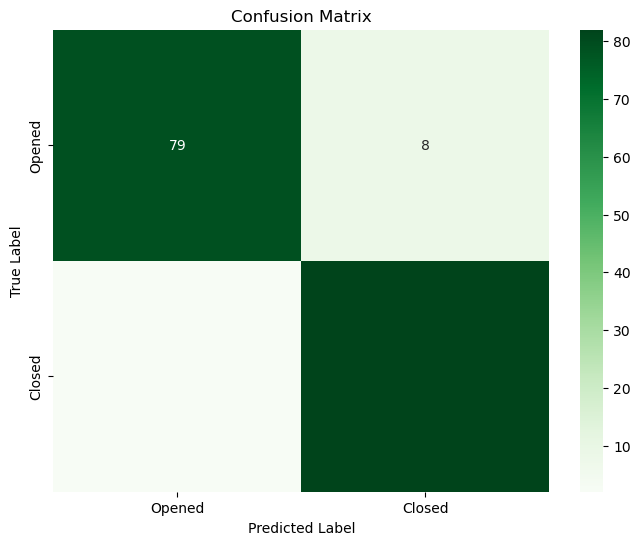

In [41]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 2**

1/1 [==============================] - 0s 79ms/step


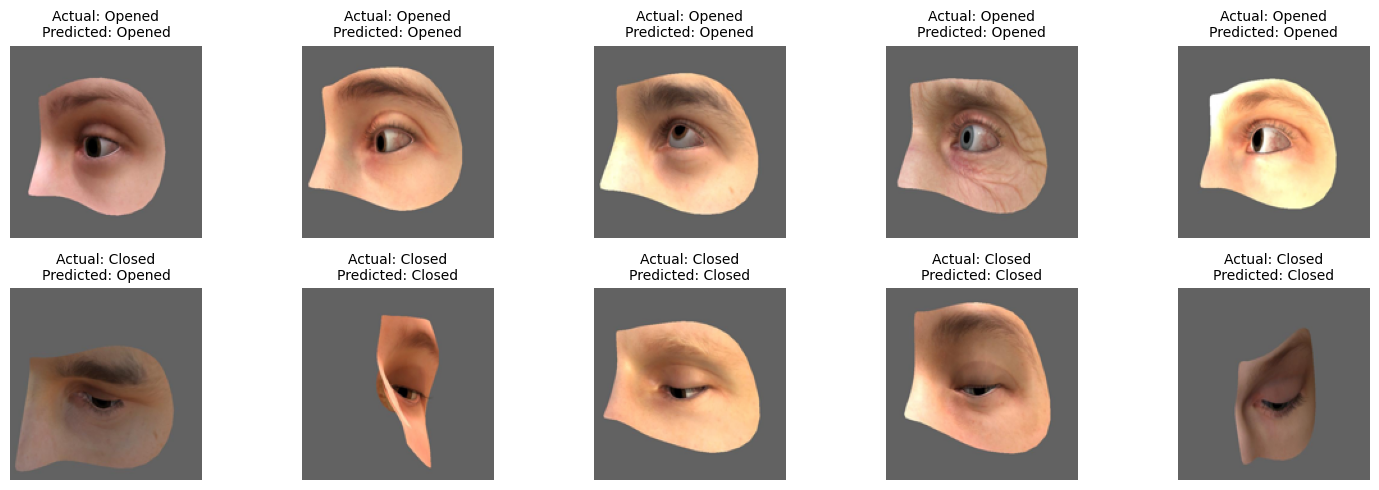

In [42]:
# Load model_predict_2 .h5
model_predict_2 = tf.keras.models.load_model('best_model_VGG16_2.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_2.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 3 CNN + VGG16 [Trainable layer - Regularization No - Batch Size 32]**

Model ketiga adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 dengan melakukan training layer VGG16, tanpa regularization dan batch size = 32

In [43]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka layer convolutional dan pooling tertentu untuk dilatih
conv_count, pool_count = 0, 0
for layer in reversed(base_model.layers):  # Iterasi dari belakang
    if isinstance(layer, tf.keras.layers.Conv2D) and conv_count < 5:
        layer.trainable = True
        conv_count += 1
    elif isinstance(layer, tf.keras.layers.MaxPooling2D) and pool_count < 3:
        layer.trainable = True
        pool_count += 1
    else:
        layer.trainable = False  # Freeze layer lainnya

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_VGG16_3
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_VGG16_3
model_VGG16_3 = Model(inputs, outputs)

# Compile model_VGG16_3
model_VGG16_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_3 = ModelCheckpoint(
    'best_model_VGG16_3.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_3 dengan batch size 32
batch_size = 32
historyVGG16_3 = model_VGG16_3.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_3, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9119
Epoch 1: val_accuracy improved from -inf to 0.96491, saving model to best_model_VGG16_3.h5
48/48 [==============================] - 170s 4s/step - loss: 0.2806 - accuracy: 0.9119 - val_loss: 0.1153 - val_accuracy: 0.9649
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9530
Epoch 2: val_accuracy did not improve from 0.96491
48/48 [==============================] - 150s 3s/step - loss: 0.1359 - accuracy: 0.9530 - val_loss: 0.1095 - val_accuracy: 0.9649
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9667
Epoch 3: val_accuracy improved from 0.96491 to 0.98246, saving model to best_model_VGG16_3.h5
48/48 [==============================] - 153s 3s/step - loss: 0.0920 - accuracy: 0.9667 - val_loss: 0.1203 - val_accuracy: 0.9825
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.965

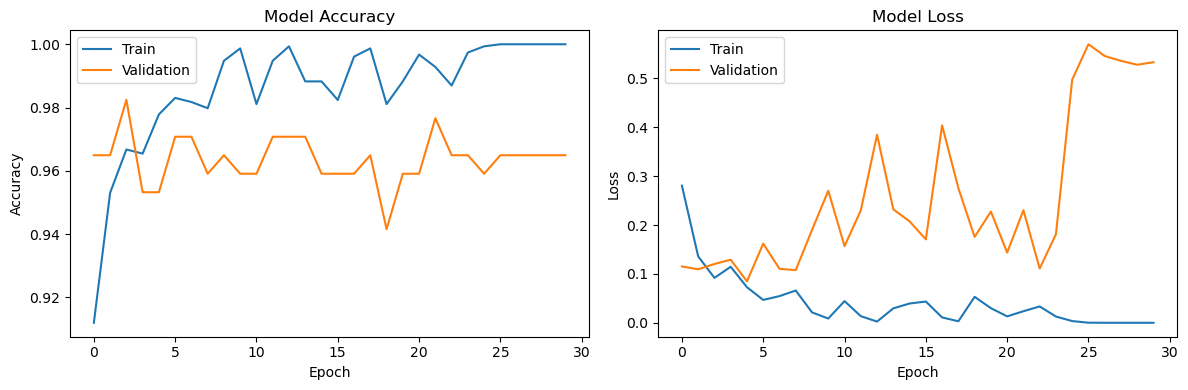

In [44]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_3.history['accuracy'])
ax1.plot(historyVGG16_3.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_3.history['loss'])
ax2.plot(historyVGG16_3.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [45]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_3.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_3.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_3 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 3:')
print(class_report_VGG16_3)

6/6 [==============================] - 8s 1s/step - loss: 0.5333 - accuracy: 0.9649
validation accuracy: 96.491%
validation loss: 0.5333
6/6 [==============================] - 9s 1s/step
Classification Report Model CNN + VGG16 3:
              precision    recall  f1-score   support

      Opened       0.98      0.95      0.97        87
      Closed       0.95      0.98      0.96        84

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171



Confusion Matrix:
[[83  4]
 [ 2 82]]


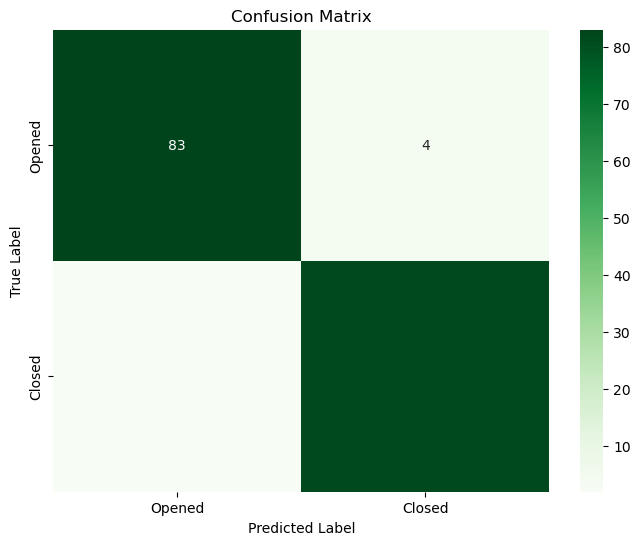

In [46]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 3**

1/1 [==============================] - 0s 78ms/step


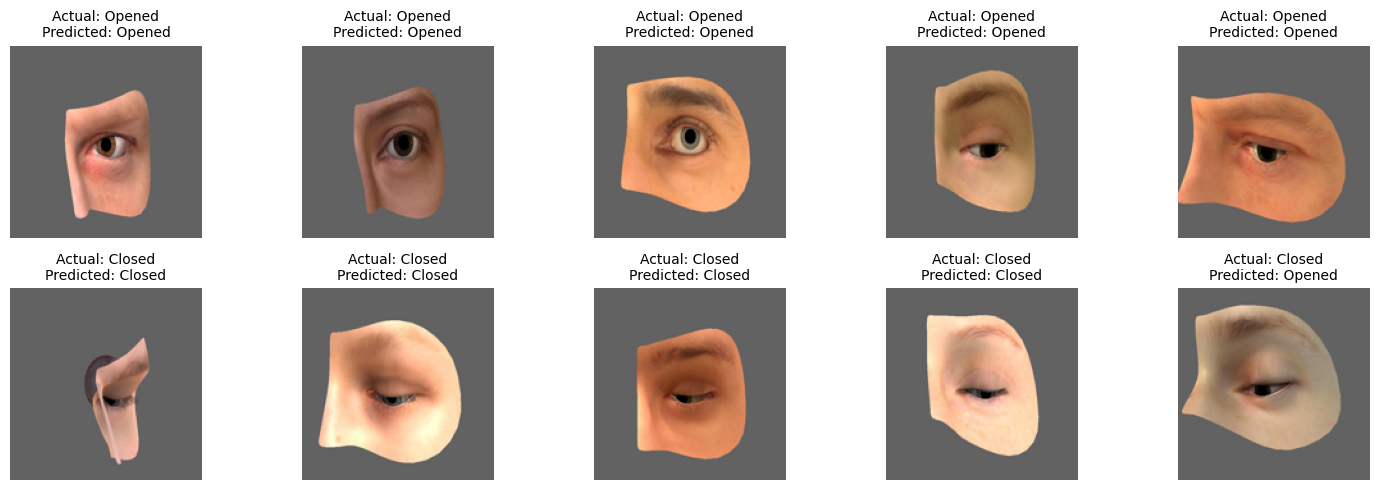

In [47]:
# Load model_predict_3 .h5
model_predict_3 = tf.keras.models.load_model('best_model_VGG16_3.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_3.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 4 CNN + VGG16 [No Trainable layer - Regularization No - Batch Size 32]**

Model keempat adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 tanpa melakukan training layer VGG16, tanpa regularization dan batch size = 32

In [48]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_VGG16_4
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_VGG16_4
model_VGG16_4 = Model(inputs, outputs)

# Compile model_VGG16_4
model_VGG16_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_4 = ModelCheckpoint(
    'best_model_VGG16_4.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_4 dengan batch size 32
batch_size = 32
historyVGG16_4 = model_VGG16_4.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_4, custom_early_stopping],
    verbose=1
)

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 1.5969 - accuracy: 0.7228
Epoch 1: val_accuracy improved from -inf to 0.91813, saving model to best_model_VGG16_4.h5
48/48 [==============================] - 95s 2s/step - loss: 1.5969 - accuracy: 0.7228 - val_loss: 0.4146 - val_accuracy: 0.9181
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.8813
Epoch 2: val_accuracy improved from 0.91813 to 0.92398, saving model to best_model_VGG16_4.h5
48/48 [==============================] - 106s 2s/step - loss: 0.5871 - accuracy: 0.8813 - val_loss: 0.3512 - val_accuracy: 0.9240
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.4789 - accuracy: 0.9054
Epoch 3: val_accuracy improved from 0.92398 to 0.92982, saving model to best_model_VGG16_4.h5
48/48 [==============================] - 95s 2s/step - loss: 0.4789 - accuracy: 0.9054 - val_loss: 0.2569 - val_accuracy: 0.9298
Epoch 4/30
48/48 [==============================] -

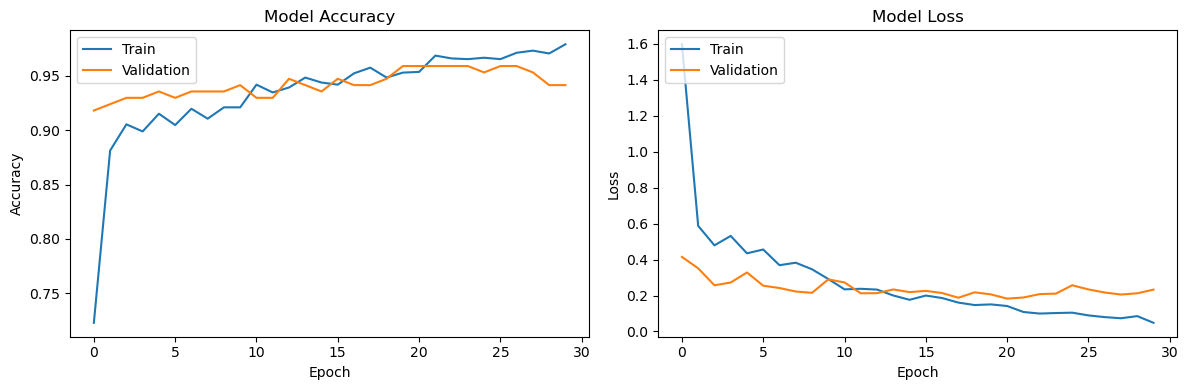

In [49]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_4.history['accuracy'])
ax1.plot(historyVGG16_4.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_4.history['loss'])
ax2.plot(historyVGG16_4.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [50]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_4.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_4.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_4 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 4:')
print(class_report_VGG16_4)

6/6 [==============================] - 8s 1s/step - loss: 0.2328 - accuracy: 0.9415
validation accuracy: 94.152%
validation loss: 0.2328
6/6 [==============================] - 9s 1s/step
Classification Report Model CNN + VGG16 4:
              precision    recall  f1-score   support

      Opened       0.96      0.92      0.94        87
      Closed       0.92      0.96      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[80  7]
 [ 3 81]]


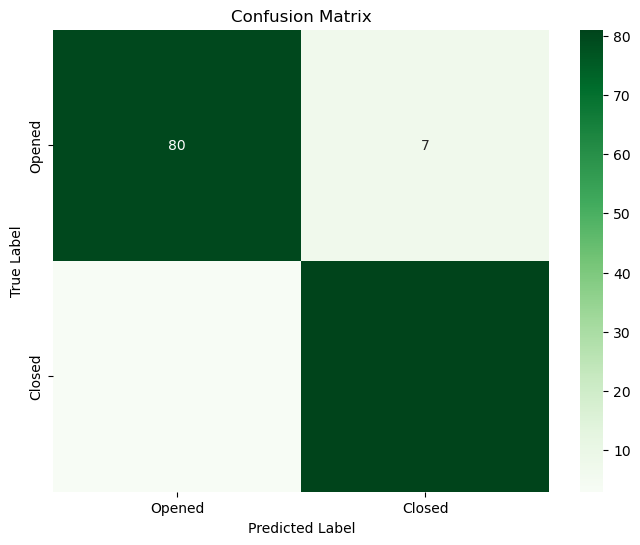

In [51]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 4**

1/1 [==============================] - 0s 79ms/step


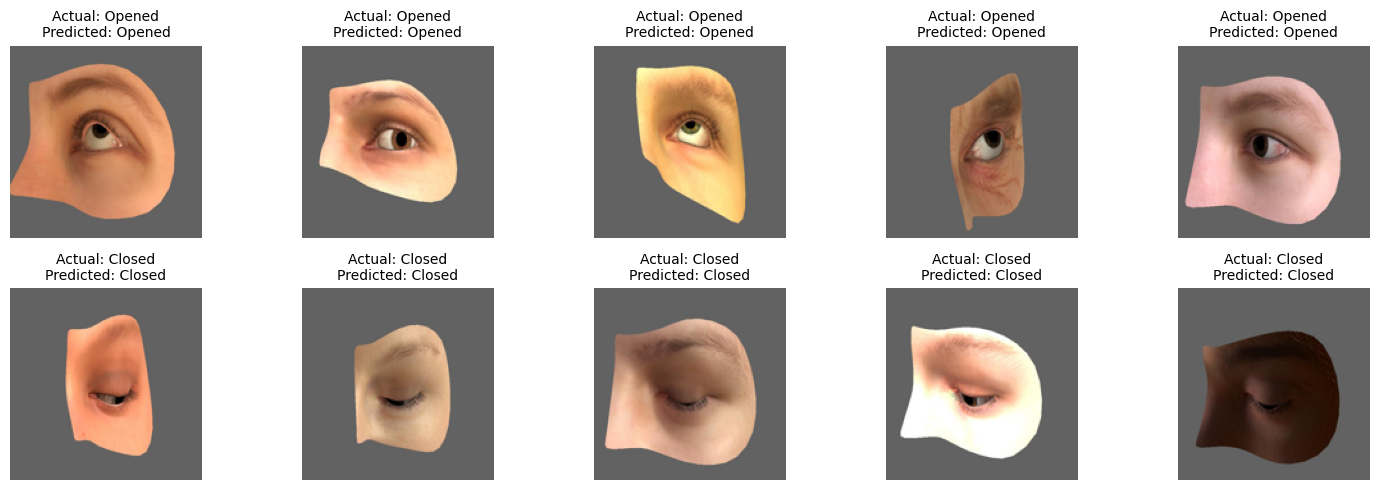

In [52]:
# Load model_predict_4 .h5
model_predict_4 = tf.keras.models.load_model('best_model_VGG16_4.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_4.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 5 CNN + VGG16 [Trainable layer - Regularization Yes - Batch Size 64]**

Model kelima adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 dengan melakukan training layer VGG16, memakai regularization dan batch size = 64

In [53]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka layer convolutional dan pooling tertentu untuk dilatih
conv_count, pool_count = 0, 0
for layer in reversed(base_model.layers):  # Iterasi dari belakang
    if isinstance(layer, tf.keras.layers.Conv2D) and conv_count < 5:
        layer.trainable = True
        conv_count += 1
    elif isinstance(layer, tf.keras.layers.MaxPooling2D) and pool_count < 3:
        layer.trainable = True
        pool_count += 1
    else:
        layer.trainable = False  # Freeze layer lainnya

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_VGG16_5
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(0.01)  # Menambahkan weight regularization
)(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_VGG16_5
model_VGG16_5 = Model(inputs, outputs)

# Compile model_VGG16_5
model_VGG16_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_5 = ModelCheckpoint(
    'best_model_VGG16_5.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_5 dengan batch size 64
batch_size = 64
historyVGG16_5 = model_VGG16_5.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_5, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 7.2900 - accuracy: 0.8219
Epoch 1: val_accuracy improved from -inf to 0.92398, saving model to best_model_VGG16_5.h5
24/24 [==============================] - 148s 6s/step - loss: 7.2900 - accuracy: 0.8219 - val_loss: 6.5573 - val_accuracy: 0.9240
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 6.2820 - accuracy: 0.9432
Epoch 2: val_accuracy improved from 0.92398 to 0.95906, saving model to best_model_VGG16_5.h5
24/24 [==============================] - 147s 6s/step - loss: 6.2820 - accuracy: 0.9432 - val_loss: 5.9747 - val_accuracy: 0.9591
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 5.7680 - accuracy: 0.9576
Epoch 3: val_accuracy did not improve from 0.95906
24/24 [==============================] - 146s 6s/step - loss: 5.7680 - accuracy: 0.9576 - val_loss: 5.5090 - val_accuracy: 0.9532
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 5.2939 - accuracy: 0.963

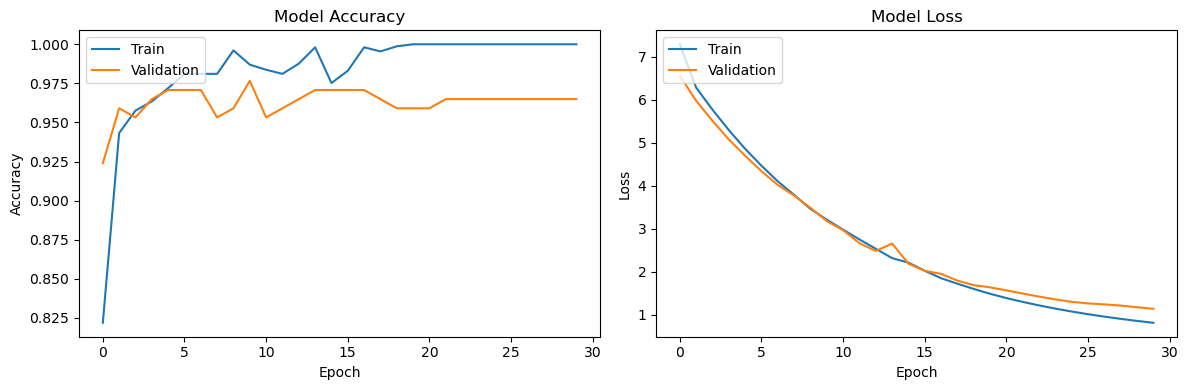

In [54]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_5.history['accuracy'])
ax1.plot(historyVGG16_5.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_5.history['loss'])
ax2.plot(historyVGG16_5.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [55]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_5.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_5.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_5 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 5:')
print(class_report_VGG16_5)

6/6 [==============================] - 11s 2s/step - loss: 1.1380 - accuracy: 0.9649
validation accuracy: 96.491%
validation loss: 1.1380
6/6 [==============================] - 11s 2s/step
Classification Report Model CNN + VGG16 5:
              precision    recall  f1-score   support

      Opened       0.98      0.95      0.97        87
      Closed       0.95      0.98      0.96        84

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171



Confusion Matrix:
[[83  4]
 [ 2 82]]


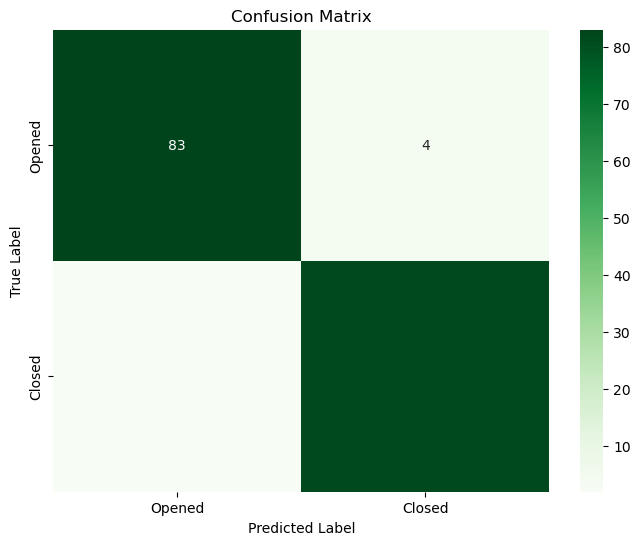

In [56]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 5**

1/1 [==============================] - 0s 116ms/step


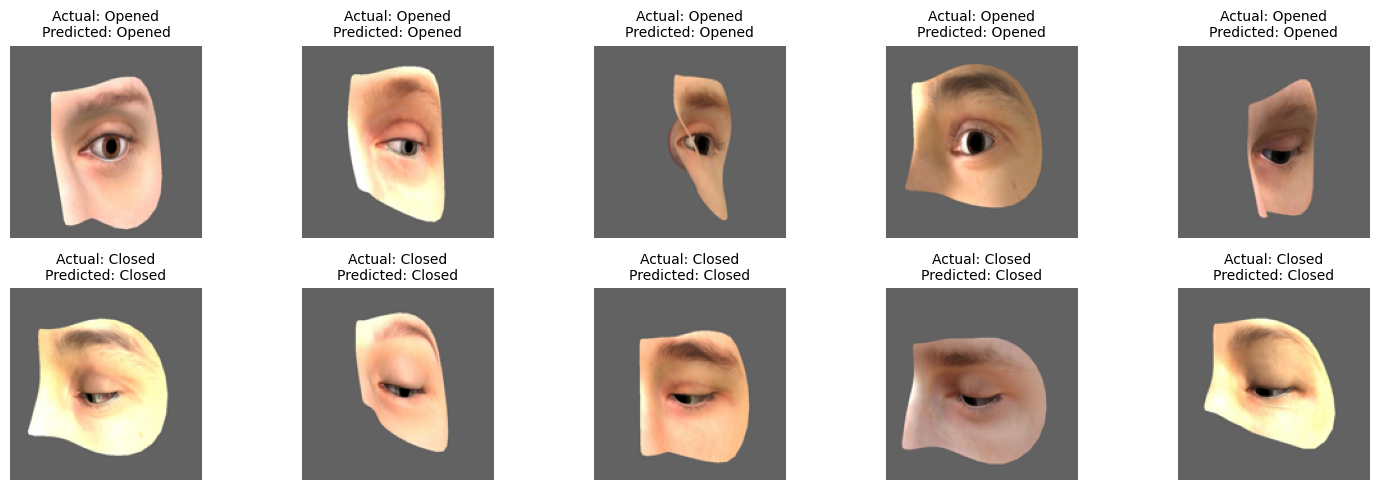

In [57]:
# Load model_predict_5 .h5
model_predict_5 = tf.keras.models.load_model('best_model_VGG16_5.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_5.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 6 CNN + VGG16 [No Trainable layer - Regularization Yes - Batch Size 64]**

Model keenam adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 tanpa melakukan training layer VGG16, memakai regularization dan batch size = 64

In [58]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_VGG16_6
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_VGG16_6
model_VGG16_6 = Model(inputs, outputs)

# Compile model_VGG16_6
model_VGG16_6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_6 = ModelCheckpoint(
    'best_model_VGG16_6.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_6 dengan batch size 64
batch_size = 64
historyVGG16_6 = model_VGG16_6.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_6, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 8.7782 - accuracy: 0.6432
Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to best_model_VGG16_6.h5
24/24 [==============================] - 112s 5s/step - loss: 8.7782 - accuracy: 0.6432 - val_loss: 6.8513 - val_accuracy: 0.8889
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 7.0255 - accuracy: 0.8526
Epoch 2: val_accuracy did not improve from 0.88889
24/24 [==============================] - 117s 5s/step - loss: 7.0255 - accuracy: 0.8526 - val_loss: 6.5141 - val_accuracy: 0.8889
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 6.5479 - accuracy: 0.8780
Epoch 3: val_accuracy improved from 0.88889 to 0.90058, saving model to best_model_VGG16_6.h5
24/24 [==============================] - 114s 5s/step - loss: 6.5479 - accuracy: 0.8780 - val_loss: 6.1081 - val_accuracy: 0.9006
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 6.1924 - accuracy: 0.883

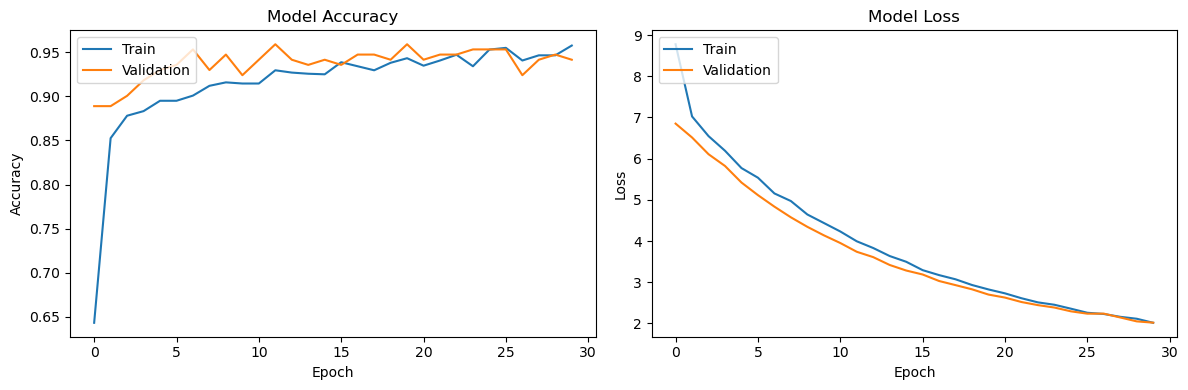

In [59]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_6.history['accuracy'])
ax1.plot(historyVGG16_6.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_6.history['loss'])
ax2.plot(historyVGG16_6.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [60]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_6.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_6.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_6 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG1619 6:')
print(class_report_VGG16_6)

6/6 [==============================] - 11s 2s/step - loss: 2.0179 - accuracy: 0.9415
validation accuracy: 94.152%
validation loss: 2.0179
6/6 [==============================] - 9s 1s/step
Classification Report Model CNN + VGG1619 6:
              precision    recall  f1-score   support

      Opened       0.98      0.91      0.94        87
      Closed       0.91      0.98      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Confusion Matrix:
[[79  8]
 [ 2 82]]


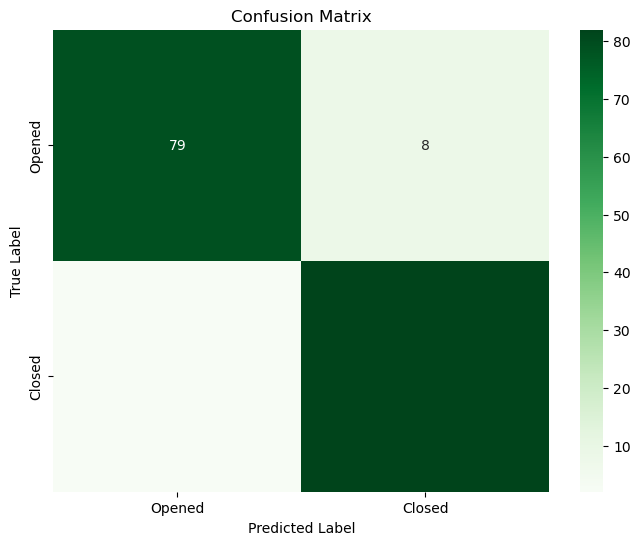

In [61]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 6**

1/1 [==============================] - 0s 78ms/step


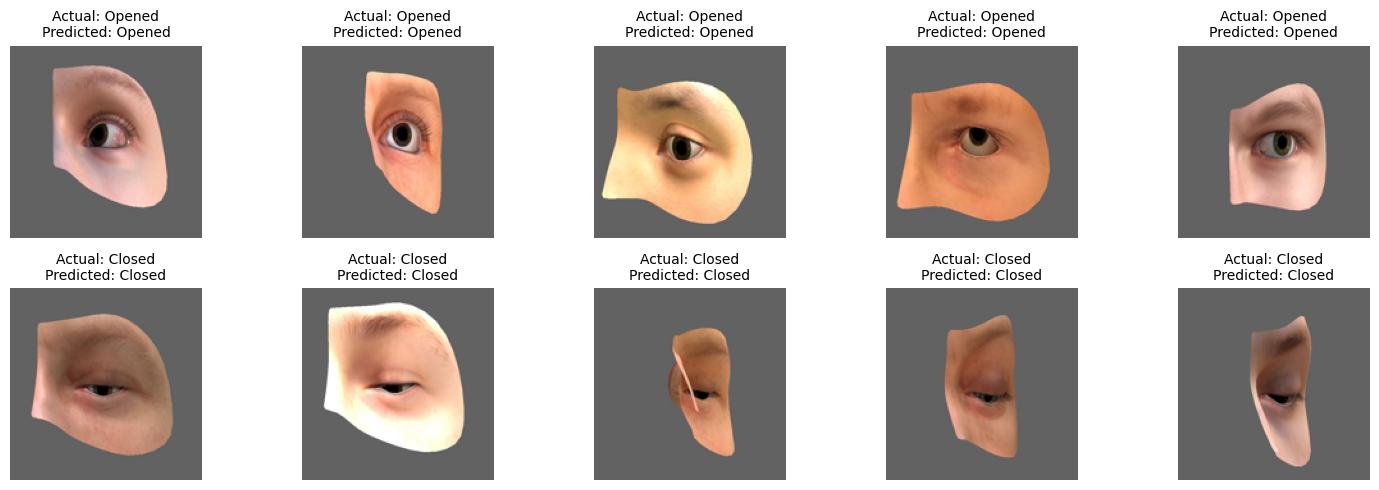

In [62]:
# Load model_predict_6 .h5
model_predict_6 = tf.keras.models.load_model('best_model_VGG16_6.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_6.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 7 CNN + VGG16 [Trainable layer - Regularization No - Batch Size 64]**

Model ketujuh adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 dengan melakukan training layer VGG16, tanpa regularization dan batch size = 64

In [63]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Membuka layer convolutional dan pooling tertentu untuk dilatih
conv_count, pool_count = 0, 0
for layer in reversed(base_model.layers):  # Iterasi dari belakang
    if isinstance(layer, tf.keras.layers.Conv2D) and conv_count < 5:
        layer.trainable = True
        conv_count += 1
    elif isinstance(layer, tf.keras.layers.MaxPooling2D) and pool_count < 3:
        layer.trainable = True
        pool_count += 1
    else:
        layer.trainable = False  # Freeze layer lainnya

# Membuat input layer
inputs = Input(shape=(150, 150, 3))

# Menyusun model_VGG16_7
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(
    1024, 
    activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

# Membuat model_VGG16_7
model_VGG16_7 = Model(inputs, outputs)

# Compile model_VGG16_7
model_VGG16_7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_7 = ModelCheckpoint(
    'best_model_VGG16_7.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_7 dengan batch size 64
batch_size = 64
historyVGG16_7 = model_VGG16_7.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_7, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.8050
Epoch 1: val_accuracy improved from -inf to 0.95322, saving model to best_model_VGG16_7.h5
24/24 [==============================] - 151s 6s/step - loss: 0.6438 - accuracy: 0.8050 - val_loss: 0.1426 - val_accuracy: 0.9532
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9446
Epoch 2: val_accuracy improved from 0.95322 to 0.95906, saving model to best_model_VGG16_7.h5
24/24 [==============================] - 149s 6s/step - loss: 0.1685 - accuracy: 0.9446 - val_loss: 0.1272 - val_accuracy: 0.9591
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9583
Epoch 3: val_accuracy improved from 0.95906 to 0.98246, saving model to best_model_VGG16_7.h5
24/24 [==============================] - 148s 6s/step - loss: 0.1134 - accuracy: 0.9583 - val_loss: 0.0937 - val_accuracy: 0.9825
Epoch 4/30
24/24 [==============================]

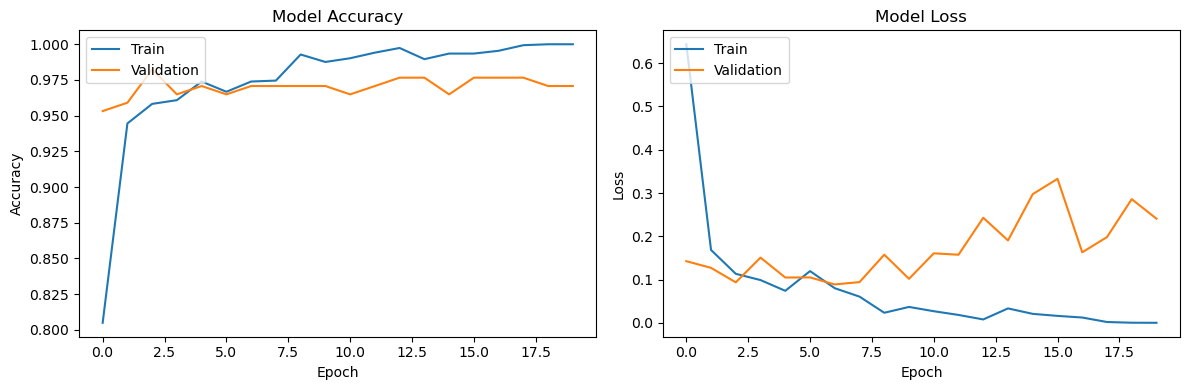

In [64]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_7.history['accuracy'])
ax1.plot(historyVGG16_7.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_7.history['loss'])
ax2.plot(historyVGG16_7.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [65]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_7.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_7.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_7 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 7:')
print(class_report_VGG16_7)

6/6 [==============================] - 9s 1s/step - loss: 0.1018 - accuracy: 0.9708
validation accuracy: 97.076%
validation loss: 0.1018
6/6 [==============================] - 9s 2s/step
Classification Report Model CNN + VGG16 7:
              precision    recall  f1-score   support

      Opened       0.98      0.97      0.97        87
      Closed       0.96      0.98      0.97        84

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



Confusion Matrix:
[[84  3]
 [ 2 82]]


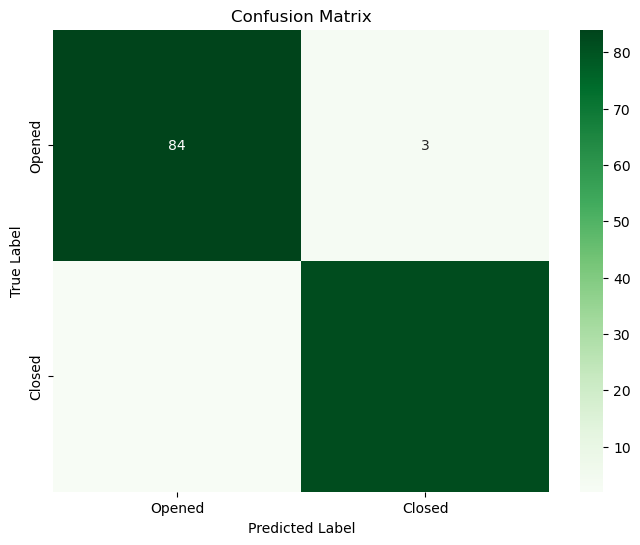

In [66]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 7**

1/1 [==============================] - 0s 80ms/step


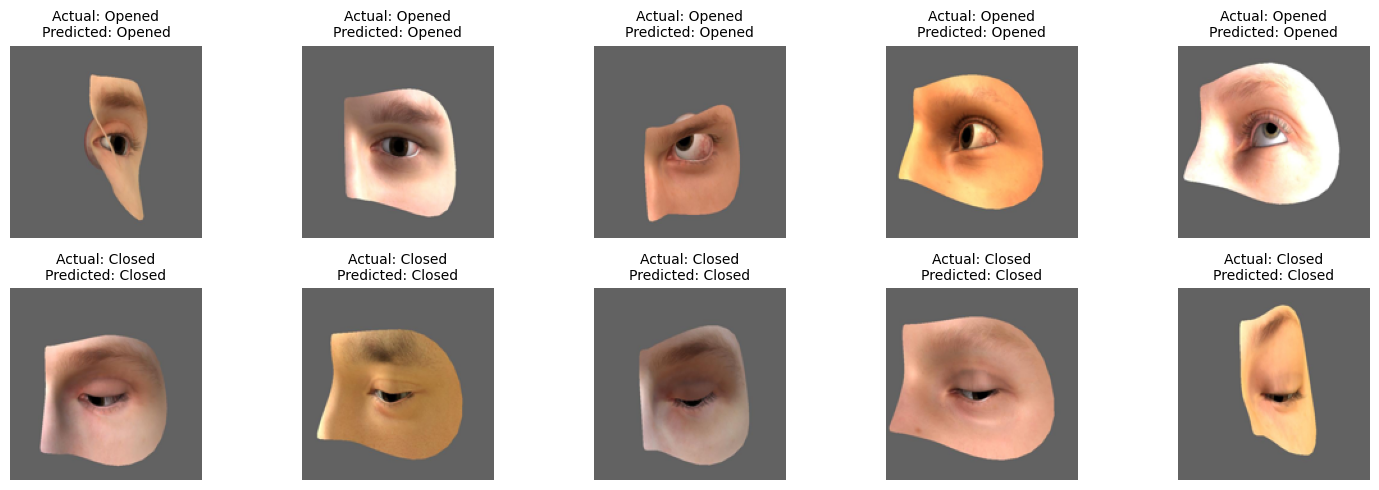

In [67]:
# Load model_predict_7 .h5
model_predict_7 = tf.keras.models.load_model('best_model_VGG16_7.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_7.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model 8 CNN + VGG16 [No Trainable layer - Regularization No - Batch Size 64]**

Model kedepalapn adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout 0.3 lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik, lalu parameter yang akan dibandingkan adalah model CNN yang disuntikan model transfer learning VGG16 tanpa melakukan training layer VGG16, tanpa regularization dan batch size = 64

In [68]:
# Load base model dengan VGG16
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    classes=2,
)

# Freeze model transfer learning dengan trainable = False (dinonaktifkan tariningnya)
base_model.trainable = False

# Menyusun model_VGG16_8
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# Membuat model_VGG16_8
model_VGG16_8 = Model(inputs, outputs)

# Compile model_VGG16_8
model_VGG16_8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Membuat checkpoint callback
checkpointVGG16_8 = ModelCheckpoint(
    'best_model_VGG16_8.h5', monitor='val_accuracy', verbose=1, save_best_only=True
)

# Early stopping minimal 10 epochs
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, min_epochs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Cegah stop sebelum min_epochs terpenuhi
        if epoch + 1 < self.min_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Custom EarlyStopping
custom_early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_epochs=10
)

# Training model_VGG16_8 dengan batch size 64
batch_size = 64
historyVGG16_8 = model_VGG16_8.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=30,
    validation_data=(x_validation, y_validation),
    callbacks=[checkpointVGG16_8, custom_early_stopping],
    verbose=1
)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 1.2136 - accuracy: 0.7430
Epoch 1: val_accuracy improved from -inf to 0.91813, saving model to best_model_VGG16_8.h5
24/24 [==============================] - 89s 4s/step - loss: 1.2136 - accuracy: 0.7430 - val_loss: 0.3732 - val_accuracy: 0.9181
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.6400 - accuracy: 0.8728
Epoch 2: val_accuracy did not improve from 0.91813
24/24 [==============================] - 88s 4s/step - loss: 0.6400 - accuracy: 0.8728 - val_loss: 0.2936 - val_accuracy: 0.9181
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.8950
Epoch 3: val_accuracy did not improve from 0.91813
24/24 [==============================] - 91s 4s/step - loss: 0.5541 - accuracy: 0.8950 - val_loss: 0.2798 - val_accuracy: 0.9181
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.9087
Epoch 4: val_accuracy did not improve from 0

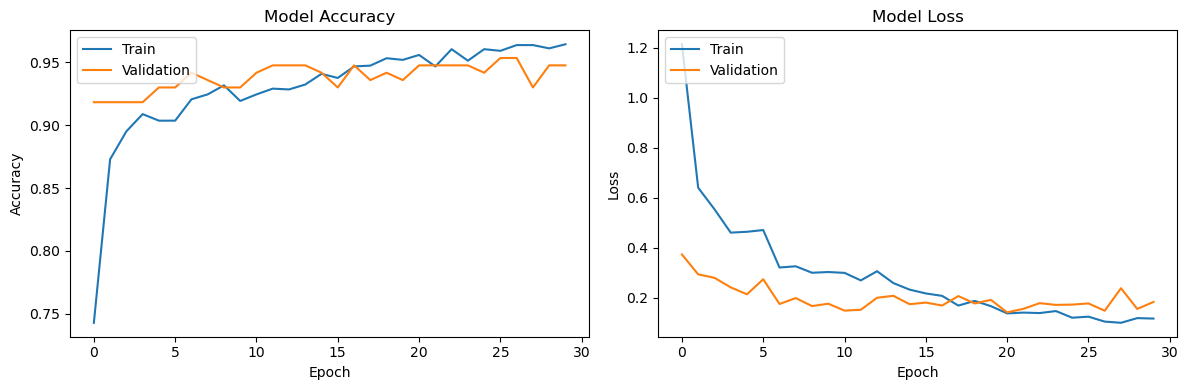

In [69]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG16_8.history['accuracy'])
ax1.plot(historyVGG16_8.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG16_8.history['loss'])
ax2.plot(historyVGG16_8.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [70]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model_VGG16_8.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model_VGG16_8.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report_VGG16_8 = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report Model CNN + VGG16 8:')
print(class_report_VGG16_8)

6/6 [==============================] - 9s 2s/step - loss: 0.1833 - accuracy: 0.9474
validation accuracy: 94.737%
validation loss: 0.1833
6/6 [==============================] - 9s 1s/step
Classification Report Model CNN + VGG16 8:
              precision    recall  f1-score   support

      Opened       0.96      0.93      0.95        87
      Closed       0.93      0.96      0.95        84

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



Confusion Matrix:
[[81  6]
 [ 3 81]]


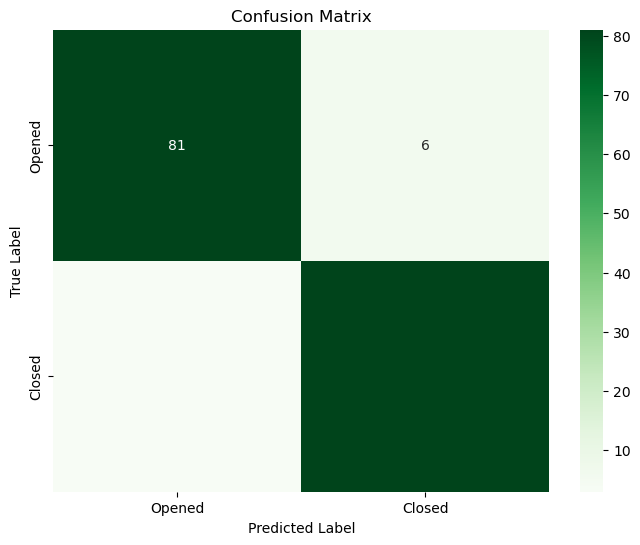

In [71]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### **Predict the New Data with Model VGG16 8**

1/1 [==============================] - 0s 79ms/step


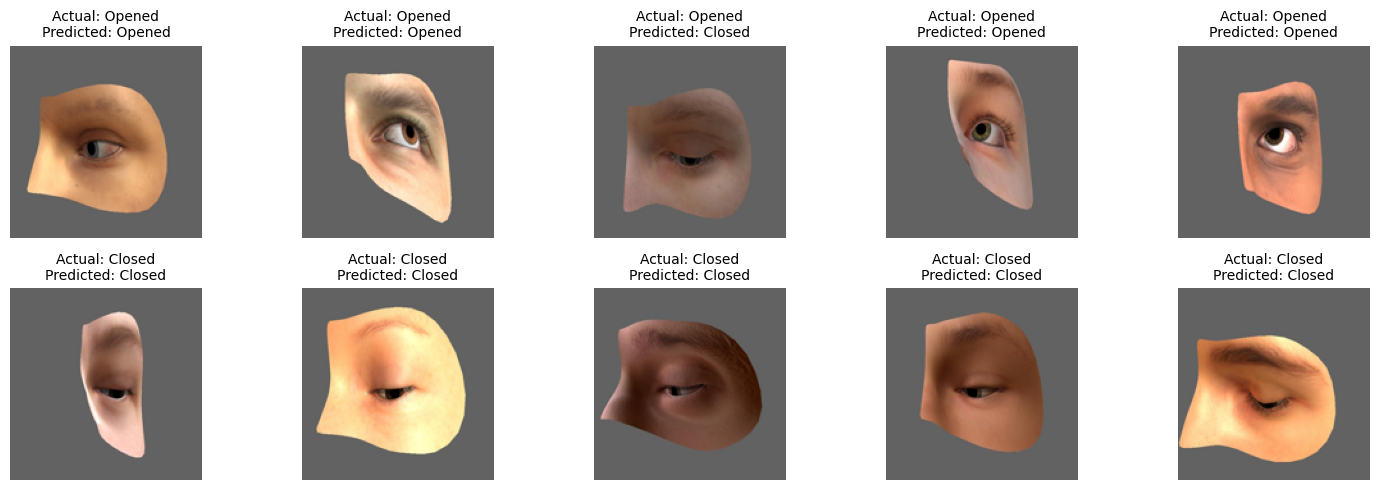

In [72]:
# Load model_predict_8 .h5
model_predict_8 = tf.keras.models.load_model('best_model_VGG16_8.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model_predict_8.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model Evaluation**

In [73]:
import time

# List model file paths
model_paths = [
    'best_model_VGG16_1.h5',
    'best_model_VGG16_2.h5',
    'best_model_VGG16_3.h5',
    'best_model_VGG16_4.h5',
    'best_model_VGG16_5.h5',
    'best_model_VGG16_6.h5',
    'best_model_VGG16_7.h5',
    'best_model_VGG16_8.h5'
]

# Placeholder untuk nama kategori
categories = ['Opened', 'Closed']  # Sesuaikan dengan kategori Anda

# Loop untuk mengevaluasi setiap model
for model_path in model_paths:
    print(f"\n# Evaluasi model: {model_path}")
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Start timer untuk runtime
    start_time = time.time()
    
    # Evaluasi model pada validation set
    validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation, verbose=1)
    
    # Prediksi untuk classification report
    y_pred = model.predict(x_validation, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_validation, axis=1)
    
    # Hitung runtime
    runtime = time.time() - start_time
    
    # Classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=categories)

    # confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Tampilkan hasil evaluasi
    print(f"\nRuntime: {runtime:.1f} s")
    print(f"Validation Accuracy: {validation_accuracy * 100:.3f}%")
    print(f"Validation Loss: {validation_loss:.4f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)



# Evaluasi model: best_model_VGG16_1.h5
6/6 [==============================] - 10s 2s/step

Runtime: 21.6 s
Validation Accuracy: 97.661%
Validation Loss: 0.9851
Classification Report:
              precision    recall  f1-score   support

      Opened       0.98      0.98      0.98        87
      Closed       0.98      0.98      0.98        84

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion Matrix:
[[85  2]
 [ 2 82]]

# Evaluasi model: best_model_VGG16_2.h5
6/6 [==============================] - 10s 2s/step

Runtime: 19.4 s
Validation Accuracy: 95.906%
Validation Loss: 2.0065
Classification Report:
              precision    recall  f1-score   support

      Opened       0.98      0.94      0.96        87
      Closed       0.94      0.98      0.96        84

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96     

## **Kesimpulan**

Pada project Computer Vision ini menggunakan algoritma Convolutional Neural Network yang disuntikan model transfer learning VGG16 dengan membandingkan jika sebuah Model CNN dilakukan trainable pada beberapa layer transfer learning, diberi atau tidak diberikan parameter regularizer dan perbedaan batch size. Kedelapan model CNN ini dapat dibandingkan untuk melihat model mana yang menghasilkan akurasi paling baik, runtime terendah, dan loss terendah. Berikut adalah hasil perbadingan akurasi dari keempat model:

1. Model CNN VGG16 1 dengan Trainable layer, dengan Regularizers, dan batch Size 32 ===> `Loss: 0.9851 ; Validation Acc: 97.6% ; F1-Score: 98% (21.6 s)`
2. Model CNN VGG16 2 tanpa Trainable layer, dengan Regularizers dan batch Size 32 =====> `Loss: 2.0065 ; Validation Acc: 95.9% ; F1-Score: 96% (19.4 s)`
3. Model CNN VGG16 3 dengan Trainable layer, tanpa Regularizers, dan batch Size 32 ====> `Loss: 0.1203 ; Validation Acc: 98.2% ; F1-Score: 98% (20.0 s`)
4. Model CNN VGG16 4 tanpa Trainable layer, tanpa Regularizers, dan batch Size 32 =====> `Loss: 0.2062 ; Validation Acc: 95.9% ; F1-Score: 96% (19.5 s)`
5. Model CNN VGG16 5 dengan Trainable layer, dengan Regularizers, dan batch Size 64 ===> `Loss: 3.1780 ; Validation Acc: 97.6% ; F1-Score: 98% (20.2 s)`
6. Model CNN VGG16 6 tanpa Trainable layer, dengan Regularizers, dan batch Size 64 ====> `Loss: 3.7391 ; Validation Acc: 95.9% ; F1-Score: 96% (19.3 s)`
7. **Model CNN VGG16 7 dengan Trainable layer, tanpa Regularizers, dan batch Size 64 ====> `Loss: 0.0937 ; Validation Acc: 98.2% ; F1-Score: 98% (20.5 s`)**
8. Model CNN VGG16 8 tanpa Trainable layer, tanpa Regularizers, dan batch Size 64 =====> `Loss: 0.1773 ; Validation Acc: 95.3% ; F1-Score: 95% (18.7 s)`

Seluruh model tidak memiliki overvitting maupun underfitting yang ditunjukan dari plot visualisasi loss dan akurasi data training dan validation. Oleh karena itu Model **CNN VGG16 7 dengan Trainable layer, tanpa Regularizers, dan batch Size 64** menjadi model paling baik untuk dataset model kantuk ini.

Untuk pemodelan lebih lanjut, data pada folder TrainingSet dapat ditambahkan data dari ImprovementSet untuk memperbanyak data dan bisa menambah akurasi yang dihasilkan nantinya.